In [1]:
import pandas as pd
import numpy as np
from numpy import ndarray
from pandas import DataFrame
import glob
import json
from functools import reduce
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import keras.backend as K

2023-05-09 16:37:26.862525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
_frequency = 200

In [3]:
from keras.utils import to_categorical

exerciseType = to_categorical([0, 1, 2, 3, 4], 5)
exerciseType[0]

array([1., 0., 0., 0., 0.], dtype=float32)

In [4]:
exerciseType[3]

array([0., 0., 0., 1., 0.], dtype=float32)

# Класс с датасетом

In [5]:
class Dataset:
    exerciseType = to_categorical([0, 1, 2, 3, 4], 5)

    def __init__(self, is_train: bool = True, window_time: int = 1):
        self.x_fields = ["acc_gx", "acc_gy", "acc_gz", "gyr_gx", "gyr_gy", "gyr_gz"]  # "timestamp", "fixingPoint",
        self.y_fields = ["exerciseType"]

        self.df: DataFrame = DataFrame()
        self.window_size = window_time * _frequency # размер окна
        self.x = np.ndarray(shape=(0, self.window_size, len(self.x_fields))) # сырые фичи для обучения
        self.y = np.ndarray(shape=(0, 5)) # выход. массив длинною в 5 элементов, где каждый элемент - вероятность принадлежности к классу по индексу
        self.x_feature = np.ndarray(shape=(0, 1)) # фичи для обучения извлеченные из сырых
        self.y_feature = np.ndarray(shape=(0, 1)) # выход для обучения.
        self._load_data(is_train)
        self._feature_extraction()

    # загрузка данных из папки
    def _load_from_path(self, path: str):
        json_dir = path
        json_pattern = os.path.join(json_dir, '*.json')
        file_list = glob.glob(json_pattern)
        dfs = []

        def convert(data, count):
            local_buffer = []

            def lamb(x: dict):
                x['id'] = count
                x["acc" + '_gx'] = x.pop('gx')
                x["acc" + '_gy'] = x.pop('gy')
                x["acc" + '_gz'] = x.pop('gz')
                return x

            size = min(len(data['accelerometerValue']), len(data['gyroscopeValue']))
            size = size - size % self.window_size  # кейс, когда данных не хватает, мы тогда обрезаем датасет под целочисленный размер окна
            data['accelerometerValue'] = data['accelerometerValue'][:size]
            data['gyroscopeValue'] = data['gyroscopeValue'][:size]

            c = list(map(lamb, data['accelerometerValue']))

            for i in range(size):
                c[i]["gyr" + '_gx'] = data['gyroscopeValue'][i]['gx']
                c[i]["gyr" + '_gy'] = data['gyroscopeValue'][i]['gy']
                c[i]["gyr" + '_gz'] = data['gyroscopeValue'][i]['gz']

            return list(c)

        count = 0
        for file in file_list:

            buffer = []
            with open(file) as f:
                reading = json.loads(f.read())

            for line in reading:
                dat = convert(line['data'], count)[:_frequency * line['duration']]
                pd_data = pd.json_normalize(dat)
                if pd_data.shape[1] == 0:
                    continue
                pd_data_x = pd_data[self.x_fields].to_numpy().reshape(-1, self.window_size, len(self.x_fields))
                self.x = np.concatenate([self.x, pd_data_x])
                temp_y = np.concatenate(
                    [Dataset.exerciseType[line["trainId"] - 1].reshape(1, -1) for _ in
                     range(pd_data_x.shape[0])])
                self.y = np.concatenate([self.y, temp_y])
                buffer.append(dat)
                count += 1

            if len(buffer) == 0: # фикс для Сани
                continue
            buffer = reduce(lambda x, y: x + y, buffer)
            json_data = pd.json_normalize(buffer)

            dfs.append(json_data)
            buffer.clear()
        df = pd.concat(dfs)
        return df

    # загрузка тренеровочных или тестовых данных из папки
    def _load_data(self, is_train: bool = True):
        self.df = self._load_from_path("data/train") if is_train else self._load_from_path("data/test")

    def _feature_extraction(self):
        new_x = []
        for i in self.x:  # По каждой строке
            i: ndarray  # (Размер окна _1000, количество параметром _6)

            # ================ чтобы набить новые признаки, редактировать в этом окне ========================
            res = []
            n = i.shape[-1]
            for k in range(n):
                a: ndarray = i[:, k]
                res.append(a.std())
                res.append(a.mean())
                res.append(a.max())
                res.append(a.min())
                res.append(a.var())

            cov1 = np.cov(i[:,0],i[:,1])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,0],i[:,2])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,1],i[:,2])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,3],i[:,4])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,3],i[:,5])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,4],i[:,5])
            res.append(cov1[0][1])

            corr1 = np.corrcoef(i[:,0],i[:,1])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,0],i[:,2])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,1],i[:,2])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,3],i[:,4])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,3],i[:,5])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,4],i[:,5])
            res.append(corr1[0][1])


            # ================================================================================================
            new_x.append(np.array(res).reshape(1, -1))
            res.clear()

        self.x_feature = np.concatenate(new_x)
        new_y = []
        for i in self.y:
            for j in range(i.shape[-1]):
                if i[j] == 1:
                    new_y.append(j)
        self.y_feature = np.array(new_y)

In [6]:
train_ds = Dataset(is_train=True)
train_ds

In [7]:
train_ds.x_feature

array([[ 0.94610804,  0.45111548,  5.741296  , ...,  0.39876457,
        -0.96911232, -0.34439994],
       [ 2.28219751,  7.73869436, 13.498509  , ...,  0.38758848,
        -0.96784336, -0.38161019],
       [ 3.76208986,  2.93326819, 16.067488  , ...,  0.07473407,
        -0.92231576,  0.04395932],
       ...,
       [ 0.72774355,  0.96438444,  2.4588451 , ..., -0.28057567,
        -0.88917971,  0.31389487],
       [ 0.80355156,  2.45193787,  3.9025488 , ...,  0.71479726,
        -0.90620235, -0.62568921],
       [ 1.72775939, -0.79261245,  2.4133554 , ...,  0.06368452,
        -0.82204673,  0.04124928]])

In [8]:
def plot_acc(data):
    plt.plot(data[:,0])
    plt.plot(data[:,1])
    plt.plot(data[:,2])
    plt.title(f'data accelerometer')
    plt.xlabel('time')
    plt.ylabel(f'acc')
    plt.legend(['gx', 'gy', 'gz'], loc='upper left')

def plot_gyr(data):
    plt.plot(data[:,3])
    plt.plot(data[:,4])
    plt.plot(data[:,5])
    plt.title(f'data gyroscope')
    plt.xlabel('time')
    plt.ylabel(f'gyr')
    plt.legend(['gx', 'gy', 'gz'], loc='upper left')

def plot_acc_df(data):
    plt.plot(data["timestamp"], data["acc_gx"])
    plt.plot(data["timestamp"], data["acc_gy"])
    plt.plot(data["timestamp"], data["acc_gz"])
    plt.title(f'data accelerometer')
    plt.xlabel('time')
    plt.ylabel(f'acc')
    plt.legend(['gx', 'gy', 'gz'], loc='upper left')

def plot_gyr_df(data):
    plt.plot(data["timestamp"],data["gyr_gx"])
    plt.plot(data["timestamp"],data["gyr_gy"])
    plt.plot(data["timestamp"],data["gyr_gz"])
    plt.title(f'data gyroscope')
    plt.xlabel('time')
    plt.ylabel(f'gyr')
    plt.legend(['gx', 'gy', 'gz'], loc='upper left')

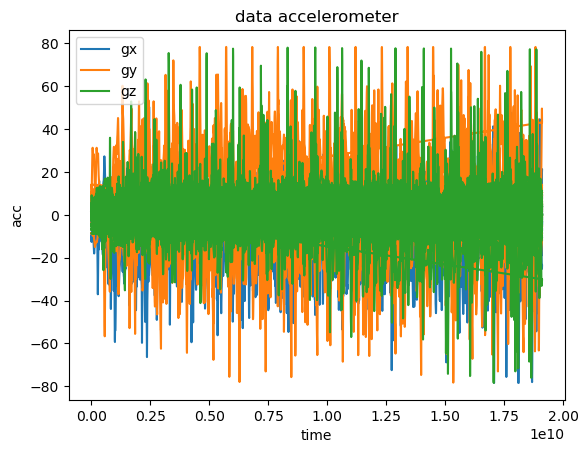

In [9]:
plot_acc_df(train_ds.df)

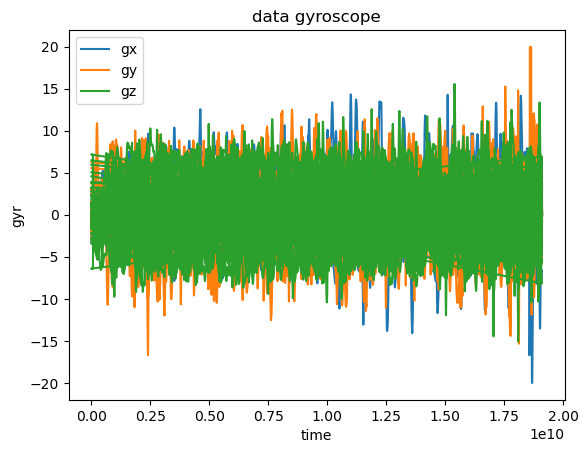

In [10]:
plot_gyr_df(train_ds.df)

# Models

In [11]:
from keras.models import Model
import keras.layers as layer

In [12]:
output_size = 5


def mlp_net_tf(data):
    """This function creates a MLP model in TensorFlow."""
    # Input:
    # data; NumPy array, data fed into the model, here only relevant to find out the input shape
    # Output:
    # model; TensorFlow / Keras model, model for training and testing

    x_input = layer.Input(shape = (data.shape[-1:]))

    x = layer.Flatten()(x_input)

    x = layer.Dense(256, activation="relu")(x) #256
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)

    x = layer.Dense(128, activation="relu")(x) #128
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)
    x_output = layer.Dense(output_size, activation="softmax")(x)

    model = Model(inputs=x_input, outputs=x_output, name="MLP_NET_TF")

    return model


def mlp_net_tf_v2(data):
    """This function creates a MLP model in TensorFlow."""
    # Input:
    # data; NumPy array, data fed into the model, here only relevant to find out the input shape
    # Output:
    # model; TensorFlow / Keras model, model for training and testing

    x_input = layer.Input(shape = (data.shape[-2:]))

    # x_input = layer.Input(8) # -2

    x = layer.Flatten()(x_input)

    x = layer.Dense(256, activation="relu")(x)
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)

    x = layer.Dense(128, activation="relu")(x)
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)
    x_output = layer.Dense(output_size, activation="softmax")(x)

    model = Model(inputs=x_input, outputs=x_output, name="MLP_NET_TF_V2")

    return model


def cnn_net_tf(data):
    """This function creates a CNN model in TensorFlow."""
    # Input:
    # data; NumPy array, data fed into the model, here only relevant to find out the input shape
    # Output:
    # model; TensorFlow / Keras model, model for training and testing

    x_input = layer.Input(shape=(data.shape[-1:]))
    # x_input = layer.Input(8) # -2

    x = layer.Conv1D(64, 10, activation="relu")(x_input)
    x = layer.BatchNormalization()(x)
    x = layer.Conv1D(128, 10, activation="relu")(x)
    x = layer.BatchNormalization()(x)

    x = layer.Flatten()(x)

    x = layer.Dense(128, activation="relu")(x)
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)
    x_output = layer.Dense(output_size, activation="softmax")(x)

    model = Model(inputs=x_input, outputs=x_output, name="CNN_NET_TF")

    return model

def cnn_net_tf_v2(data):
    """This function creates a CNN model in TensorFlow."""
    # Input:
    # data; NumPy array, data fed into the model, here only relevant to find out the input shape
    # Output:
    # model; TensorFlow / Keras model, model for training and testing

    x_input = layer.Input(shape=(data.shape[-2:]))
    # x_input = layer.Input(8) # -2

    x = layer.Conv1D(64, 10, activation="relu")(x_input)
    x = layer.BatchNormalization()(x)
    x = layer.Conv1D(128, 10, activation="relu")(x)
    x = layer.BatchNormalization()(x)

    x = layer.Flatten()(x)

    x = layer.Dense(128, activation="relu")(x)
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)
    x_output = layer.Dense(output_size, activation="softmax")(x)

    model = Model(inputs=x_input, outputs=x_output, name="CNN_NET_TF_v2")

    return model


def gru_net_tf(data):
    """This function creates a GRU model in TensorFlow."""
    # Input:
    # data; NumPy array, data fed into the model, here only relevant to find out the input shape
    # Output:
    # model; TensorFlow / Keras model, model for training and testing

    x_input = layer.Input(shape = (data.shape[-2:]))

    # x_input = layer.Input(8)  # -2

    x = layer.Bidirectional(layer.GRU(256, return_sequences=True))(x_input)
    x = layer.BatchNormalization()(x)
    x = layer.Bidirectional(layer.GRU(128, return_sequences=True))(x)
    x = layer.BatchNormalization()(x)

    x = layer.Flatten()(x)

    x = layer.Dense(128, activation="relu")(x)
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)
    x_output = layer.Dense(output_size, activation="softmax")(x)

    model = Model(inputs=x_input, outputs=x_output, name="GRU_NET_TF")

    return model


def lstm_net_tf(data):
    """This function creates a LSTM model in TensorFlow."""
    # Input:
    # data; NumPy array, data fed into the model, here only relevant to find out the input shape
    # Output:
    # model; TensorFlow / Keras model, model for training and testing

    x_input = layer.Input(shape=(data.shape[-2:]))
    # x_input = layer.Input(shape = 8)

    # w/o bidirectional

    x = layer.Bidirectional(layer.LSTM(256, return_sequences=True))(x_input)
    x = layer.BatchNormalization()(x)
    x = layer.Bidirectional(layer.LSTM(128, return_sequences=True))(x)
    x = layer.BatchNormalization()(x)

    x = layer.Flatten()(x)

    x = layer.Dense(128, activation="relu")(x)
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)
    x_output = layer.Dense(output_size, activation="softmax")(x)

    model = Model(inputs=x_input, outputs=x_output, name="LSTM_NET_TF")

    return model


def lstm_net_tf_v2(data):
    """This function creates a LSTM model in TensorFlow."""
    # Input:
    # data; NumPy array, data fed into the model, here only relevant to find out the input shape
    # Output:
    # model; TensorFlow / Keras model, model for training and testing

    # x_input = layer.Input(shape = (data.shape[-2:]))
    x_input = layer.Input(shape=8)

    # w/o bidirectional

    x = layer.Bidirectional(layer.LSTM(256, return_sequences=True))(x_input)
    x = layer.BatchNormalization()(x)
    x = layer.Bidirectional(layer.LSTM(128, return_sequences=True))(x)
    x = layer.BatchNormalization()(x)

    x = layer.Flatten()(x)

    x = layer.Dense(128, activation="relu")(x)
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)
    x_output = layer.Dense(output_size, activation="softmax")(x)

    model = Model(inputs=x_input, outputs=x_output, name="LSTM_NET_TF")

    return model


def gru_net_big_tf(data):
    """This function creates a big GRU model in TensorFlow."""
    # Input:
    # data; NumPy array, data fed into the model, here only relevant to find out the input shape
    # Output:
    # model; TensorFlow / Keras model, model for training and testing

    x_input = layer.Input(shape=(data.shape[-2:]))

    x = layer.Bidirectional(layer.GRU(512, return_sequences=True))(x_input)
    x = layer.BatchNormalization()(x)
    x = layer.Bidirectional(layer.GRU(256, return_sequences=True))(x)
    x = layer.BatchNormalization()(x)
    x = layer.Bidirectional(layer.GRU(128, return_sequences=True))(x)
    x = layer.BatchNormalization()(x)

    x = layer.Flatten()(x)

    x = layer.Dense(128, activation="relu")(x)
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)
    x_output = layer.Dense(output_size, activation="softmax")(x)

    model = Model(inputs=x_input, outputs=x_output, name="GRU_NET_BIG_TF")

    return model


def conv_lstm_net_tf(data):
    """This function creates a convolutional LSTM model in TensorFlow."""
    # Input:
    # data; NumPy array, data fed into the model, here only relevant to find out the input shape
    # Output:
    # model; TensorFlow / Keras model, model for training and testing

    x_input = layer.Input(shape=(data.shape[-4:]))

    x = layer.Bidirectional(layer.ConvLSTM2D(64, (3, 3), return_sequences=True))(x_input)
    x = layer.BatchNormalization()(x)
    x = layer.Bidirectional(layer.ConvLSTM2D(128, (3, 3), return_sequences=True))(x)
    x = layer.BatchNormalization()(x)

    x = layer.Flatten()(x)

    x = layer.Dense(128, activation="relu")(x)
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)
    x_output = layer.Dense(6, activation="softmax")(x)

    model = Model(inputs=x_input, outputs=x_output, name="CONV_LSTM_NET_TF")

    return model

In [13]:
def make_dataset(X, y, is_train):
    print(f"x=${X.shape}")
    print(f"y=${y.shape}")
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if is_train:
        dataset = dataset.shuffle(32)

    dataset = dataset.batch(4)

    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [14]:
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [15]:
window_time = 5
train_ds = Dataset(is_train=True, window_time=window_time)
test_ds = Dataset(is_train=False, window_time=window_time)

In [16]:
train_kds = make_dataset(train_ds.x_feature, train_ds.y, True)
test_kds = make_dataset(test_ds.x_feature, test_ds.y, False)

x=$(219, 42)
y=$(219, 5)
x=$(25, 42)
y=$(25, 5)


## MLP_NET_TF

In [20]:
model = mlp_net_tf(train_ds.x_feature)

In [21]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
                      metrics=["AUC", f1_metric, "Recall", "Precision", "accuracy"])

In [22]:
history = model.fit(train_kds, validation_data=test_kds, epochs=20)

Epoch 1/20
55/55 [==============================] - 2s 8ms/step - loss: 1.6417 - auc: 0.7490 - f1_metric: 0.3825 - recall: 0.3425 - precision: 0.4310 - accuracy: 0.3927 - val_loss: 1.1028 - val_auc: 0.8692 - val_f1_metric: 0.7211 - val_recall: 0.6400 - val_precision: 0.8421 - val_accuracy: 0.8400
Epoch 2/20
55/55 [==============================] - 0s 2ms/step - loss: 0.9562 - auc: 0.8962 - f1_metric: 0.6370 - recall: 0.6027 - precision: 0.6947 - accuracy: 0.6667 - val_loss: 1.1844 - val_auc: 0.8812 - val_f1_metric: 0.7211 - val_recall: 0.6400 - val_precision: 0.8889 - val_accuracy: 0.8400
Epoch 3/20
55/55 [==============================] - 0s 3ms/step - loss: 0.6529 - auc: 0.9476 - f1_metric: 0.7530 - recall: 0.7352 - precision: 0.7816 - accuracy: 0.7534 - val_loss: 1.3477 - val_auc: 0.8776 - val_f1_metric: 0.8214 - val_recall: 0.8000 - val_precision: 0.8000 - val_accuracy: 0.8000
Epoch 4/20
55/55 [==============================] - 0s 2ms/step - loss: 0.6361 - auc: 0.9519 - f1_metric: 

In [85]:
model2 = gru_net_big_tf(train_ds.x_feature)

2023-05-01 16:36:17.914045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 16:36:17.915085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 16:36:17.916354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [88]:
model2.compile(optimizer="adam", loss="categorical_crossentropy",
                      metrics=["AUC", f1_metric, "Recall", "Precision", "accuracy"])

In [89]:
history2 = model2.fit(train_kds, validation_data=test_kds, epochs=20)

Epoch 1/20


ValueError: in user code:

    File "/opt/anaconda3/envs/diplom/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/diplom/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/diplom/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/envs/diplom/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/envs/diplom/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/diplom/lib/python3.9/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "GRU_NET_BIG_TF" is incompatible with the layer: expected shape=(None, 244, 42), found shape=(None, 42)


In [25]:
def plot_metric(_history, name: str):
    plt.plot(_history.history[f'{name}'])
    plt.plot(_history.history[f'val_{name}'])
    plt.title(f'model {name}')
    plt.ylabel(f'{name}')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

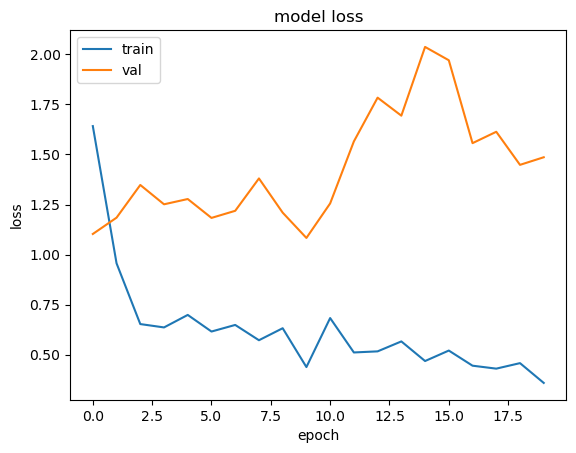

In [26]:
plot_metric(history, "loss")

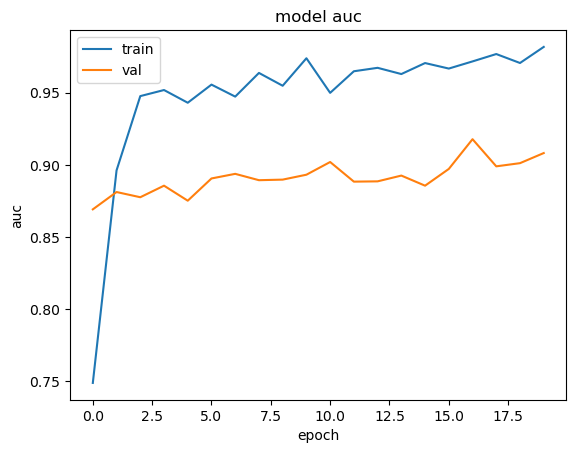

In [27]:
plot_metric(history, "auc")

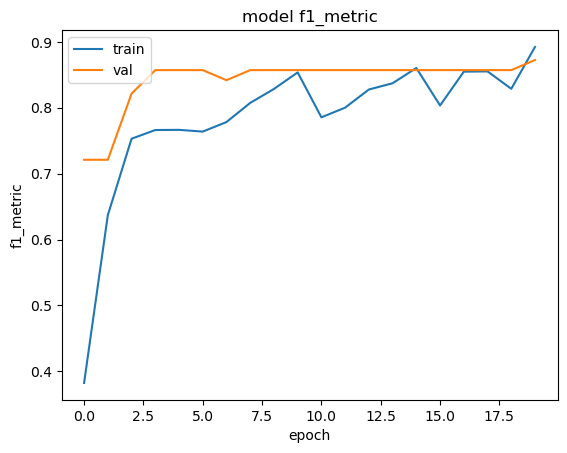

In [28]:
plot_metric(history, "f1_metric")

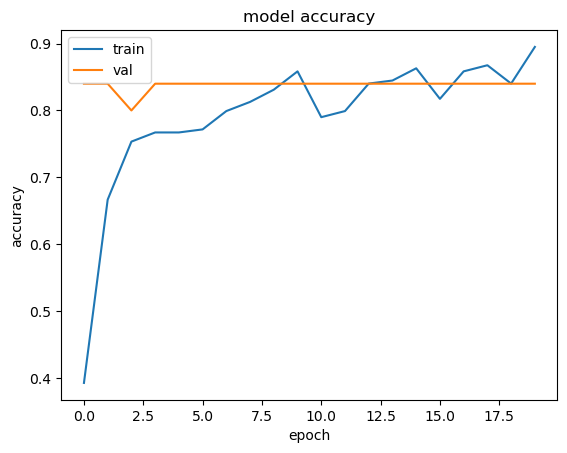

In [29]:
plot_metric(history, "accuracy")

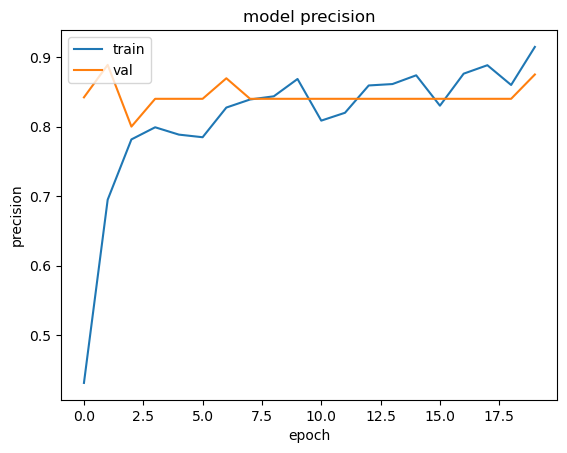

In [30]:
plot_metric(history, "precision")

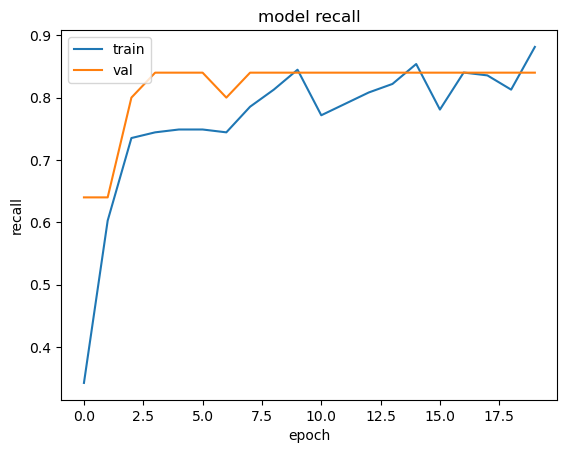

In [31]:
plot_metric(history, "recall")

In [100]:
model2 = cnn_net_tf(train_ds.x)

ValueError: Input 0 of layer "conv1d_10" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 6)

In [109]:
test_ds_predict = Dataset(is_train=False, window_time=window_time)

In [110]:
model.predict(test_ds_predict.x_feature)

1/1 [==============================] - 0s 16ms/step


array([[5.6349474e-01, 1.3058083e-01, 3.0093028e-03, 2.9191145e-01,
        1.1003641e-02],
       [8.2117957e-01, 1.1587039e-01, 9.9175749e-04, 5.2855778e-02,
        9.1026062e-03],
       [8.6666954e-01, 1.1416847e-01, 5.1914249e-04, 1.3543726e-02,
        5.0991601e-03]], dtype=float32)

In [112]:
test_ds_predict.y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [113]:
test_ds_predict.x_feature

array([[ 3.27097689e+00, -3.19179169e+00,  3.29920980e+00,
        -1.24761850e+01,  1.06992898e+01,  2.00896082e+00,
         7.60042922e+00,  1.56508960e+01,  2.95683900e+00,
         4.03592359e+00,  2.65536213e+00,  4.61436888e+00,
         1.12000750e+01, -4.81234550e-01,  7.05094803e+00,
         7.15920586e-01,  1.35040314e-01,  1.71469880e+00,
        -1.51555670e+00,  5.12542286e-01,  1.17697382e+00,
         2.62733318e-03,  3.14901040e+00, -3.45383210e+00,
         1.38526737e+00,  1.65957082e+00,  1.15677107e-01,
         2.52837130e+00, -3.66702410e+00,  2.75417530e+00,
        -2.85340511e+00, -6.61324978e+00,  1.35238075e+00,
        -2.94874486e-02,  1.04001112e+00,  7.64168567e-02,
        -4.33790443e-01, -7.60640038e-01,  2.53261541e-01,
        -3.49599684e-02,  8.74465801e-01,  3.90833756e-02],
       [ 3.92911761e+00, -3.49794545e+00,  6.27999100e+00,
        -1.45304100e+01,  1.54379652e+01,  1.86325811e+00,
         7.14671841e+00,  1.19734030e+01,  3.39497800e+